## Nhlalonhle Tsotetsi

User's Migration Final Year Project Simulation

------------------------------------------------------------------------------------------------------------------------------------------


##  1. Simulation Setup and Core Definitions

This cell sets up the entire simulation environment.  
It imports all required libraries, defines the data classes (`NetworkGeneration`, `User`, `NetworkEnvironment`, `IncentiveManager`),  
and implements the main `MigrationSimulator` class that handles user initialization, baseline and incentive simulations, and visualization methods.

Run this once at the beginning to define everything needed for the subsequent cells.


In [1]:
# --- Setup: imports, folders, seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from typing import Dict, List
from dataclasses import dataclass
import warnings, os, contextlib

warnings.filterwarnings('ignore')
os.makedirs('simulation_figures', exist_ok=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

np.random.seed(42)
random.seed(42)

# =========================
#   DATA CLASSES & USERS
# =========================
@dataclass
class NetworkGeneration:
    generation: str
    data_speed_mbps: float
    latency_ms: float
    coverage_quality: float  # 0–1
    def qos_score(self) -> float:
        smin, smax = 0.1, 100.0
        speed_score = 100 * (np.log10(max(self.data_speed_mbps, smin)) - np.log10(smin)) / (np.log10(smax) - np.log10(smin))
        speed_score = float(np.clip(speed_score, 0, 100))
        lmax = 500.0
        latency_score = 100 * (1 - min(self.latency_ms, lmax) / lmax)
        coverage_score = float(self.coverage_quality) * 100.0
        return (speed_score + latency_score + coverage_score) / 3.0

class User:
    def __init__(self, user_id: int, current_generation: str):
        self.user_id = user_id
        self.current_generation = current_generation
        self.initial_generation = current_generation
        self.price_sensitivity   = np.random.beta(2, 2) * 0.8 + 0.1
        self.technology_affinity = np.random.beta(2, 5) * 0.9 + 0.1
        self.income_level        = np.clip(np.random.lognormal(0, 0.5), 0.1, 1.0)
        self.switching_cost_sensitivity = np.random.uniform(0.1, 0.9)
        self.network_effect_sensitivity = np.random.uniform(0.1, 0.9)
        self.migration_history = []
        self.months_on_current_gen = np.random.randint(1, 24)

    def calculate_utility(self, target_generation: str, networks: Dict,
                          incentives: Dict, base_costs: Dict) -> float:
        if target_generation == self.current_generation:
            return 0.0
        current_net = networks[self.current_generation]
        target_net  = networks[target_generation]
        qos_improvement = target_net.qos_score() - current_net.qos_score()
        qos_benefit     = self.technology_affinity * qos_improvement
        econ = 0.0
        if 'device_subsidy' in incentives:   econ += incentives['device_subsidy'].get(target_generation, 0)
        if 'bundle_discount' in incentives:  econ += incentives['bundle_discount'].get(target_generation, 0)
        if 'loyalty_bonus' in incentives:    econ += incentives['loyalty_bonus'].get(target_generation, 0)
        economic_incentive = self.price_sensitivity * econ
        base_switch = base_costs.get('switching_once', 300)
        perceived_switch = base_switch * (2 - self.income_level) * (1 - 0.5 * self.technology_affinity)
        switching_penalty = self.switching_cost_sensitivity * perceived_switch / 100.0
        return qos_benefit + economic_incentive - switching_penalty

    def migration_probability(self, target_generation: str, networks: Dict,
                              incentives: Dict, base_costs: Dict) -> float:
        utility = self.calculate_utility(target_generation, networks, incentives, base_costs)
        return float(np.clip(sigmoid(utility / 50.0), 0, 1))

    def make_migration_decision(self, available_generations: List[str],
                                networks: Dict, incentives: Dict, base_costs: Dict) -> str:
        gen_levels = {'2G': 1, '3G': 2, '4G': 3, '5G': 4}
        probs = {}
        for gen in available_generations:
            if gen != self.current_generation and gen_levels[gen] > gen_levels[self.current_generation]:
                probs[gen] = self.migration_probability(gen, networks, incentives, base_costs)
        probs[self.current_generation] = 0.8  # stay bias
        total = sum(probs.values())
        if total == 0:
            return self.current_generation
        probs = {g: p / total for g, p in probs.items()}
        r, acc = random.random(), 0.0
        for g, p in probs.items():
            acc += p
            if r <= acc:
                return g
        return self.current_generation

    def migrate_to(self, new_generation: str, month: int):
        if new_generation != self.current_generation:
            self.migration_history.append({'from': self.current_generation, 'to': new_generation, 'month': month})
            self.current_generation = new_generation
            self.months_on_current_gen = 0
        else:
            self.months_on_current_gen += 1

# =========================
#   ENVIRONMENT & INCENTIVES
# =========================
class NetworkEnvironment:
    def __init__(self):
        self.networks = {
            '2G': NetworkGeneration('2G', 0.1, 500, 0.90),
            '3G': NetworkGeneration('3G', 1.0,  100, 0.80),
            '4G': NetworkGeneration('4G', 20.0, 40, 0.60),
            '5G': NetworkGeneration('5G', 100.0, 5, 0.30)
        }
        self.base_costs = {'switching_once': 300, 'plan_change': 100, 'learning_curve': 50}

    def get_available_generations(self) -> List[str]:
        return list(self.networks.keys())

    def get_network_info(self) -> pd.DataFrame:
        rows = []
        for gen, net in self.networks.items():
            rows.append({
                'Generation': gen,
                'Speed (Mbps)': net.data_speed_mbps,
                'Latency (ms)': net.latency_ms,
                'Coverage Quality': net.coverage_quality,
                'QoS Score': round(net.qos_score(), 2)
            })
        return pd.DataFrame(rows)

class IncentiveManager:
    def __init__(self): self.active_incentives = {}
    def set_device_subsidies(self, d: Dict[str, float]):   self.active_incentives['device_subsidy'] = d
    def set_bundle_discounts(self, d: Dict[str, float]):   self.active_incentives['bundle_discount'] = d
    def set_loyalty_bonuses(self, d: Dict[str, float]):    self.active_incentives['loyalty_bonus'] = d
    def clear_incentives(self):                            self.active_incentives = {}
    def get_incentive_summary(self) -> Dict:               return self.active_incentives.copy()

# =========================
#   SIMULATOR
# =========================
class MigrationSimulator:
    def __init__(self, num_users: int = 100_000):
        self.num_users = num_users
        self.env = NetworkEnvironment()
        self.incentive_mgr = IncentiveManager()
        self.users_baseline, self.users_treatment = [], []
        self.baseline_results, self.treatment_results = {}, {}
        self.initial_distribution = {}

    def initialize_users(self):
        print(f"Initializing {self.num_users} users for simulation...")
        target_pct = {'2G': 11, '3G': 49, '4G': 38, '5G': 2}
        counts = {g: self.num_users * p // 100 for g, p in target_pct.items()}
        remainder = self.num_users - sum(counts.values())
        order = ['3G', '4G', '2G', '5G']
        i = 0
        while remainder > 0:
            counts[order[i % len(order)]] += 1
            remainder -= 1
            i += 1

        self.users_baseline = []
        uid = 0
        for gen in ['2G', '3G', '4G', '5G']:
            for _ in range(counts[gen]):
                self.users_baseline.append(User(uid, gen))
                uid += 1

        self.users_treatment = []
        for i, b in enumerate(self.users_baseline):
            t = User(i + self.num_users, b.current_generation)
            t.price_sensitivity = b.price_sensitivity
            t.technology_affinity = b.technology_affinity
            t.income_level = b.income_level
            t.switching_cost_sensitivity = b.switching_cost_sensitivity
            t.network_effect_sensitivity = b.network_effect_sensitivity
            t.months_on_current_gen = b.months_on_current_gen
            t.initial_generation = b.initial_generation
            self.users_treatment.append(t)

        self.initial_distribution = self.get_initial_distribution()
        print("User populations initialized successfully.")

    def get_initial_distribution(self) -> Dict:
        counts = {}
        for u in self.users_baseline:
            counts[u.current_generation] = counts.get(u.current_generation, 0) + 1
        pcts = {g: (c / self.num_users) * 100 for g, c in counts.items()}
        return {'counts': counts, 'percentages': pcts}

    def run_baseline_simulation(self):
        print("\n--- Running Baseline Simulation (No Incentives) ---")
        self.incentive_mgr.clear_incentives()
        migration_counts = {}
        gens = self.env.get_available_generations()
        for u in self.users_baseline:
            orig = u.current_generation
            newg = u.make_migration_decision(gens, self.env.networks,
                                             self.incentive_mgr.get_incentive_summary(),
                                             self.env.base_costs)
            u.migrate_to(newg, 0)
            key = f"{orig} -> {newg}"
            migration_counts[key] = migration_counts.get(key, 0) + 1
        self.baseline_results = {
            'migration_counts': migration_counts,
            'final_distribution': self.get_final_distribution(self.users_baseline),
            'migration_rate': self.calculate_migration_rate(self.users_baseline),
            'migration_rate_excl_5g': self.calculate_migration_rate_excl_5g(self.users_baseline)
        }
        print("Baseline simulation completed.")

    def run_treatment_simulation(self, incentive_config: Dict):
        print(f"\n--- Running Treatment Simulation (With Incentives) ---")
        if 'device_subsidies' in incentive_config:
            self.incentive_mgr.set_device_subsidies(incentive_config['device_subsidies'])
        if 'bundle_discounts' in incentive_config:
            self.incentive_mgr.set_bundle_discounts(incentive_config['bundle_discounts'])
        if 'loyalty_bonuses' in incentive_config:
            self.incentive_mgr.set_loyalty_bonuses(incentive_config['loyalty_bonuses'])

        migration_counts = {}
        gens = self.env.get_available_generations()
        for u in self.users_treatment:
            orig = u.current_generation
            newg = u.make_migration_decision(gens, self.env.networks,
                                             self.incentive_mgr.get_incentive_summary(),
                                             self.env.base_costs)
            u.migrate_to(newg, 0)
            key = f"{orig} -> {newg}"
            migration_counts[key] = migration_counts.get(key, 0) + 1

        self.treatment_results = {
            'migration_counts': migration_counts,
            'final_distribution': self.get_final_distribution(self.users_treatment),
            'migration_rate': self.calculate_migration_rate(self.users_treatment),
            'migration_rate_excl_5g': self.calculate_migration_rate_excl_5g(self.users_treatment),
            'incentive_config': incentive_config
        }
        print("Treatment simulation completed.")

    def get_final_distribution(self, users: List[User]) -> Dict:
        counts = {}
        for u in users:
            counts[u.current_generation] = counts.get(u.current_generation, 0) + 1
        pcts = {g: (c / len(users)) * 100 for g, c in counts.items()}
        return {'counts': counts, 'percentages': pcts}

    def calculate_migration_rate(self, users: List[User]) -> float:
        migrated = sum(1 for u in users if len(u.migration_history) > 0)
        return (migrated / len(users)) * 100

    def calculate_migration_rate_excl_5g(self, users: List[User]) -> float:
        eligible = [u for u in users if getattr(u, 'initial_generation', u.current_generation) != '5G']
        if not eligible:
            return 0.0
        migrated = sum(1 for u in eligible if len(u.migration_history) > 0)
        return (migrated / len(eligible)) * 100

    def get_network_info_df(self) -> pd.DataFrame:
        return self.env.get_network_info()

    # ======= Visuals you already use =======
    def create_migration_flow_sankey(self):
        source_counts = self.initial_distribution['counts']
        fig1, ax1 = plt.subplots(figsize=(9, 8))
        base_flows = self._prepare_migration_flow_data(self.baseline_results['migration_counts'], source_counts)
        self._plot_migration_flow_heatmap(base_flows, ax1, "Baseline Migration Flows (No Incentives)")
        plt.tight_layout()
        plt.savefig('simulation_figures/migration_flows_baseline.png', dpi=300, bbox_inches='tight')
        plt.savefig('simulation_figures/migration_flows_baseline.pdf', bbox_inches='tight')
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(9, 8))
        trt_flows = self._prepare_migration_flow_data(self.treatment_results['migration_counts'], source_counts)
        self._plot_migration_flow_heatmap(trt_flows, ax2, "Incentive Migration Flows (With Incentives)")
        plt.tight_layout()
        plt.savefig('simulation_figures/migration_flows_treatment.png', dpi=300, bbox_inches='tight')
        plt.savefig('simulation_figures/migration_flows_treatment.pdf', bbox_inches='tight')
        plt.show()

    def _prepare_migration_flow_data(self, migration_counts: Dict, source_counts: Dict) -> np.ndarray:
        gens = ['2G', '3G', '4G', '5G']
        n = len(gens)
        flow = np.zeros((n, n), dtype=float)
        for key, count in migration_counts.items():
            if '->' in key:
                src, dst = key.split(' -> ')
                if src in gens and dst in gens:
                    i, j = gens.index(src), gens.index(dst)
                    flow[i, j] += count
        for i, src in enumerate(gens):
            denom = float(source_counts.get(src, 0))
            flow[i, :] = (flow[i, :] / denom) * 100.0 if denom > 0 else 0.0
        return flow

    def _plot_migration_flow_heatmap(self, flow_matrix: np.ndarray, ax, title: str):
        gens = ['2G', '3G', '4G', '5G']
        im = ax.imshow(flow_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
        ax.set_xticks(np.arange(len(gens))); ax.set_yticks(np.arange(len(gens)))
        ax.set_xticklabels(gens); ax.set_yticklabels(gens)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        for i in range(len(gens)):
            for j in range(len(gens)):
                val = flow_matrix[i, j]
                if val >= 1.0:
                    ax.text(j, i, f'{val:.1f}%', ha="center", va="center", color="black", fontweight='bold', fontsize=10)
                elif val > 0:
                    ax.text(j, i, f'{val:.2f}%', ha="center", va="center", color="black", fontsize=8)
        ax.set_xlabel('Target Generation'); ax.set_ylabel('Source Generation')
        ax.set_title(title, fontsize=14, fontweight='bold')
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('% of source cohort')

    def create_distribution_comparison_charts(self):
        gens = ['2G', '3G', '4G', '5G']
        x = np.arange(len(gens)); w = 0.35

        fig1, ax1 = plt.subplots(figsize=(8,6))
        init = [self.initial_distribution['percentages'].get(g,0) for g in gens]
        base = [self.baseline_results['final_distribution']['percentages'].get(g,0) for g in gens]
        ax1.bar(x - w/2, init, w, label='Initial Subscribers', color='lightblue', alpha=0.8)
        ax1.bar(x + w/2, base, w, label='Final Subscribers (Baseline)', color='lightcoral', alpha=0.8)
        ax1.set_title('Distribution Comparison: Baseline (No Incentives)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Percentage of Users (%)'); ax1.set_xlabel('Network Generation')
        ax1.set_xticks(x); ax1.set_xticklabels(gens); ax1.legend(); ax1.grid(axis='y', alpha=0.3)
        for i,(a,b) in enumerate(zip(init,base)):
            ax1.text(i - w/2, a + 1, f'{a:.1f}%', ha='center', fontsize=9)
            ax1.text(i + w/2, b + 1, f'{b:.1f}%', ha='center', fontsize=9)
        plt.tight_layout()
        plt.savefig('simulation_figures/distribution_comparison_baseline.png', dpi=300, bbox_inches='tight')
        plt.savefig('simulation_figures/distribution_comparison_baseline.pdf', bbox_inches='tight')
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(8,6))
        trt = [self.treatment_results['final_distribution']['percentages'].get(g,0) for g in gens]
        ax2.bar(x - w/2, init, w, label='Initial Subscribers', color='lightblue', alpha=0.8)
        ax2.bar(x + w/2, trt,  w, label='Final Subscribers (Incentives)', color='lightgreen', alpha=0.8)
        ax2.set_title('Distribution Comparison: Incentive Scenario', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Percentage of Users (%)'); ax2.set_xlabel('Network Generation')
        ax2.set_xticks(x); ax2.set_xticklabels(gens); ax2.legend(); ax2.grid(axis='y', alpha=0.3)
        for i,(a,b) in enumerate(zip(init,trt)):
            ax2.text(i - w/2, a + 1, f'{a:.1f}%', ha='center', fontsize=9)
            ax2.text(i + w/2, b + 1, f'{b:.1f}%', ha='center', fontsize=9)
        plt.tight_layout()
        plt.savefig('simulation_figures/distribution_comparison_treatment.png', dpi=300, bbox_inches='tight')
        plt.savefig('simulation_figures/distribution_comparison_treatment.pdf', bbox_inches='tight')
        plt.show()

# =========================
#   QUIET HELPERS + DONUTS
# =========================
def _silent(fn, *args, **kwargs):
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        return fn(*args, **kwargs)

def _fresh_sim(num_users, seed_np, seed_py):
    np.random.seed(seed_np); random.seed(seed_py)
    sim = MigrationSimulator(num_users=num_users)
    _silent(sim.initialize_users)
    return sim

def draw_two_donuts(b_rate, t_rate, title="Overall Migration Rate (eligible users; 5G starters excluded)"):
    def _donut(ax, rate, subtitle):
        vals = [rate, max(0, 100-rate)]
        wedges, _ = ax.pie(vals, startangle=90, counterclock=False,
                           wedgeprops=dict(width=0.35, edgecolor='white'))
        ax.add_artist(plt.Circle((0,0), 0.65, color='white'))
        ax.text(0, 0, f"{rate:.1f}%", ha='center', va='center', fontsize=14, fontweight='bold')
        ax.set_title(subtitle, fontsize=12, fontweight='bold')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4.2))
    _donut(axes[0], b_rate, "Baseline")
    _donut(axes[1], t_rate, "With incentives")
    fig.suptitle(title, fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig('simulation_figures/migration_rate_donuts_baseline_vs_incentives.png', dpi=300, bbox_inches='tight')
    plt.savefig('simulation_figures/migration_rate_donuts_baseline_vs_incentives.pdf', bbox_inches='tight')
    plt.show()

def plot_incentive_migration_rate_donuts(num_users=100_000):
    # Single-incentive scenarios (others zero)
    DEVICE_ONLY = {'device_subsidies': {'4G': 500, '5G': 1000}}
    BUNDLE_ONLY = {'bundle_discounts': {'4G': 50, '5G': 150}}
    LOYALTY_ONLY = {'loyalty_bonuses': {'5G': 200}}

    seed_np, seed_py = 31415, 27182  # identical cohorts

    def _single_rate(cfg):
        sim = _fresh_sim(num_users, seed_np, seed_py)
        _silent(sim.run_baseline_simulation)
        _silent(sim.run_treatment_simulation, cfg)
        return sim.treatment_results['migration_rate_excl_5g']

    r_device  = _single_rate(DEVICE_ONLY)
    r_bundle  = _single_rate(BUNDLE_ONLY)
    r_loyalty = _single_rate(LOYALTY_ONLY)

    def _draw(ax, rate, title):
        vals = [rate, max(0, 100 - rate)]
        ax.pie(vals, startangle=90, counterclock=False,
               wedgeprops=dict(width=0.35, edgecolor='white'))
        ax.add_artist(plt.Circle((0,0), 0.65, color='white'))
        ax.text(0, 0, f"{rate:.1f}%", ha='center', va='center', fontsize=14, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold')

    fig, axs = plt.subplots(1, 3, figsize=(12, 4.2))
    _draw(axs[0], r_device,  "Device subsidy only")
    _draw(axs[1], r_bundle,  "Bundle discount only")
    _draw(axs[2], r_loyalty, "Loyalty bonus only")
    fig.suptitle("Overall Migration Rate by Incentive (eligible users; 5G starters excluded)", fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.savefig('simulation_figures/incentive_migration_rate_donuts.png', dpi=300, bbox_inches='tight')
    plt.savefig('simulation_figures/incentive_migration_rate_donuts.pdf', bbox_inches='tight')
    plt.show()


------------------------------------------------------------------------------------------------------------------------------------------
## 2. Initialize Simulation and Display Environment Setup

This cell creates the simulation environment and initializes **100 000 users** based on the GSMA adoption distribution for Sub-Saharan Africa (2G = 11 %, 3G = 49 %, 4G = 38 %, 5G = 2 %).  

It also:
- Displays the **initial user distribution** across generations.
- Displays the **network environment parameters** (data rate, latency, coverage, and QoS score).

This step establishes the baseline population before running any simulations.


In [2]:
# Incentive configuration (used later for the full incentive run)
INCENTIVE_CONFIG = {
    'device_subsidies': {'4G': 500, '5G': 1000},
    'bundle_discounts': {'4G': 50,  '5G': 150},
    'loyalty_bonuses':  {'5G': 200}
}

sim = MigrationSimulator(num_users=100_000)
sim.initialize_users()

print("Initial Distribution (exact):")
for gen in ['2G', '3G', '4G', '5G']:
    c = sim.initial_distribution['counts'].get(gen, 0)
    p = sim.initial_distribution['percentages'].get(gen, 0)
    print(f"  {gen}: {c:,} users ({p:.1f}%)")

print("\nNetwork Environment Information:")
display(sim.get_network_info_df())


Initializing 100000 users for simulation...
User populations initialized successfully.
Initial Distribution (exact):
  2G: 11,000 users (11.0%)
  3G: 49,000 users (49.0%)
  4G: 38,000 users (38.0%)
  5G: 2,000 users (2.0%)

Network Environment Information:


,Generation,Speed (Mbps),Latency (ms),Coverage Quality,QoS Score
0,2G,0.1,500,0.9,30.00
1,3G,1.0,100,0.8,64.44
2,4G,20.0,40,0.6,76.23
3,5G,100.0,5,0.3,76.33


------------------------------------------------------------------------------------------------------------------------------------------
## 3. Run Baseline Simulation (No Incentives)

This cell executes the **baseline scenario**, where users migrate solely based on perceived QoS improvements and switching costs —  
no economic incentives are applied.

It outputs:
- Overall migration rate 
- Final network distribution (how many users remain or move to each generation)
- Migration flow statistics (source → target transitions)

This represents the natural migration behavior in the absence of operator incentives.


In [3]:
sim.run_baseline_simulation()

print(f"Overall Migration Rate (all users): {sim.baseline_results['migration_rate']:.1f}%")
print(f"Overall Migration Rate (eligible; 5G excluded): {sim.baseline_results['migration_rate_excl_5g']:.1f}%\n")

print("Final Distribution (Baseline):")
for gen in ['2G', '3G', '4G', '5G']:
    c = sim.baseline_results['final_distribution']['counts'].get(gen, 0)
    p = sim.baseline_results['final_distribution']['percentages'].get(gen, 0)
    print(f"  {gen}: {c:,} users ({p:.1f}%)")

print("\nMigration Flows (counts over entire population):")
for k, count in sorted(sim.baseline_results['migration_counts'].items()):
    if count > 0 and '->' in k:
        s, t = k.split(' -> ')
        if s != t:
            pct = (count / sim.num_users) * 100
            print(f"  {k}: {count:,} users ({pct:.2f}%)")



--- Running Baseline Simulation (No Incentives) ---
Baseline simulation completed.
Overall Migration Rate (all users): 49.5%
Overall Migration Rate (eligible; 5G excluded): 50.5%

Final Distribution (Baseline):
  2G: 3,529 users (3.5%)
  3G: 23,908 users (23.9%)
  4G: 39,816 users (39.8%)
  5G: 32,747 users (32.7%)

Migration Flows (counts over entire population):
  2G -> 3G: 2,439 users (2.44%)
  2G -> 4G: 2,512 users (2.51%)
  2G -> 5G: 2,520 users (2.52%)
  3G -> 4G: 13,757 users (13.76%)
  3G -> 5G: 13,774 users (13.77%)
  4G -> 5G: 14,453 users (14.45%)


------------------------------------------------------------------------------------------------------------------------------------------

## 4. Run Incentive-Based Simulation

This cell runs the **incentive-driven simulation**, applying the three active operator incentives:
- Device Subsidy (R 500 for 4G / R 1000 for 5G)
- Bundle Discount (R 50 for 4G / R 150 for 5G)
- Loyalty Bonus (R 200 for 5G)

It outputs:
- Active incentive configuration
- Migration rate under incentives
- Final user distribution
- Migration flows between generations

This step models operator-driven interventions to accelerate user migration.


In [4]:
print("Active incentives:")
for k, v in INCENTIVE_CONFIG.items():
    print(f"  {k}: {v}")

sim.run_treatment_simulation(INCENTIVE_CONFIG)

print(f"\nOverall Migration Rate (all users): {sim.treatment_results['migration_rate']:.1f}%")
print(f"Overall Migration Rate (eligible; 5G excluded): {sim.treatment_results['migration_rate_excl_5g']:.1f}%\n")

print("Final Distribution (Incentives):")
for gen in ['2G', '3G', '4G', '5G']:
    c = sim.treatment_results['final_distribution']['counts'].get(gen, 0)
    p = sim.treatment_results['final_distribution']['percentages'].get(gen, 0)
    print(f"  {gen}: {c:,} users ({p:.1f}%)")

print("\nMigration Flows (counts over entire population):")
for k, count in sorted(sim.treatment_results['migration_counts'].items()):
    if count > 0 and '->' in k:
        s, t = k.split(' -> ')
        if s != t:
            pct = (count / sim.num_users) * 100
            print(f"  {k}: {count:,} users ({pct:.2f}%)")


Active incentives:
  device_subsidies: {'4G': 500, '5G': 1000}
  bundle_discounts: {'4G': 50, '5G': 150}
  loyalty_bonuses: {'5G': 200}

--- Running Treatment Simulation (With Incentives) ---
Treatment simulation completed.

Overall Migration Rate (all users): 64.2%
Overall Migration Rate (eligible; 5G excluded): 65.5%

Final Distribution (Incentives):
  2G: 2,640 users (2.6%)
  3G: 16,056 users (16.1%)
  4G: 37,534 users (37.5%)
  5G: 43,770 users (43.8%)

Migration Flows (counts over entire population):
  2G -> 3G: 1,899 users (1.90%)
  2G -> 4G: 3,212 users (3.21%)
  2G -> 5G: 3,249 users (3.25%)
  3G -> 4G: 17,323 users (17.32%)
  3G -> 5G: 17,520 users (17.52%)
  4G -> 5G: 21,001 users (21.00%)


------------------------------------------------------------------------------------------------------------------------------------------

## 5. Compare Baseline vs Incentive Scenarios

This cell computes and displays the **difference in migration rates** between the baseline and incentive scenarios,  
focusing on eligible users (excluding those who already started on 5G).

It reports:
- Baseline migration rate  
- Incentive-driven migration rate  
- Percentage-point improvement (Δ pp)

Provides a concise quantitative comparison of incentive effectiveness.


In [5]:
b = sim.baseline_results['migration_rate_excl_5g']
t = sim.treatment_results['migration_rate_excl_5g']
delta = t - b
print("COMPARISON: BASELINE vs INCENTIVES (eligible users; 5G starters excluded)")
print(f"  Baseline:  {b:.1f}%")
print(f"  Incentive: {t:.1f}%")
print(f"  Improvement: +{delta:.1f} pp")


COMPARISON: BASELINE vs INCENTIVES (eligible users; 5G starters excluded)
  Baseline:  50.5%
  Incentive: 65.5%
  Improvement: +15.1 pp


------------------------------------------------------------------------------------------------------------------------------------------

## 6. Plot Distribution Comparison Charts

This cell generates **bar charts** comparing the user distribution:
- Initial vs Final (Baseline)
- Initial vs Final (Incentive Scenario)

Visualizes how incentives shifted user adoption across network generations.


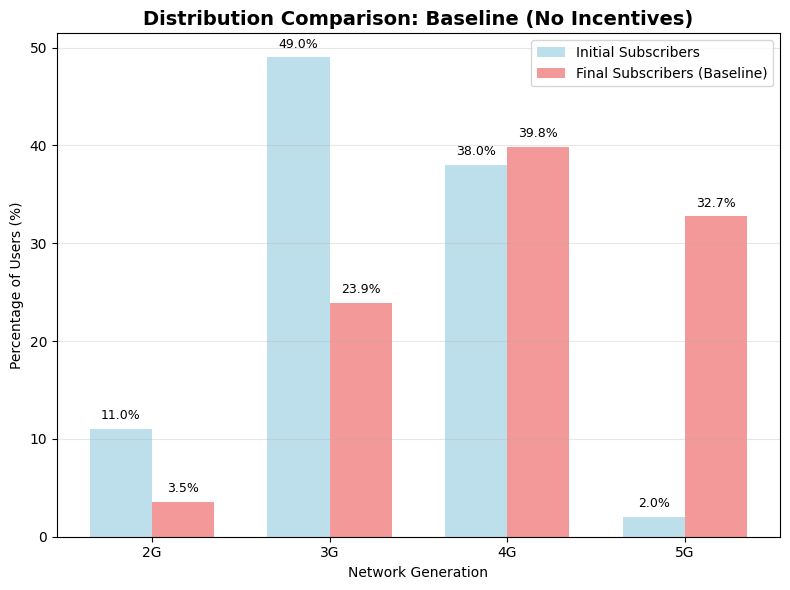

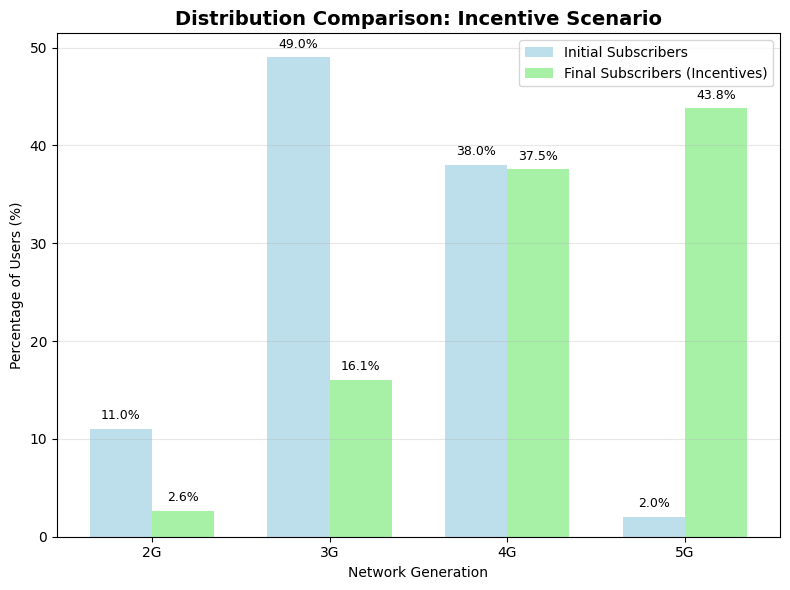

In [6]:
sim.create_distribution_comparison_charts()


------------------------------------------------------------------------------------------------------------------------------------------

## 7. Plot Migration Flow Heatmaps

This cell creates **row-normalized heatmaps** showing user movement between network generations:
- Baseline ( No Incentives )
- Incentive ( With Incentives )

Reveals detailed migration paths and highlights upgrade bottlenecks.


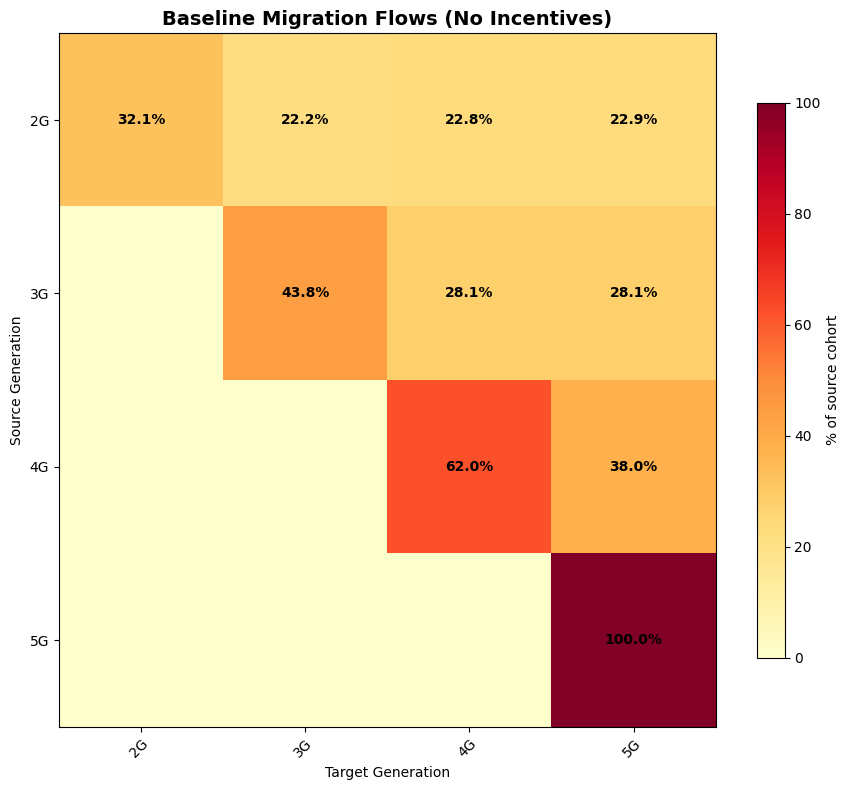

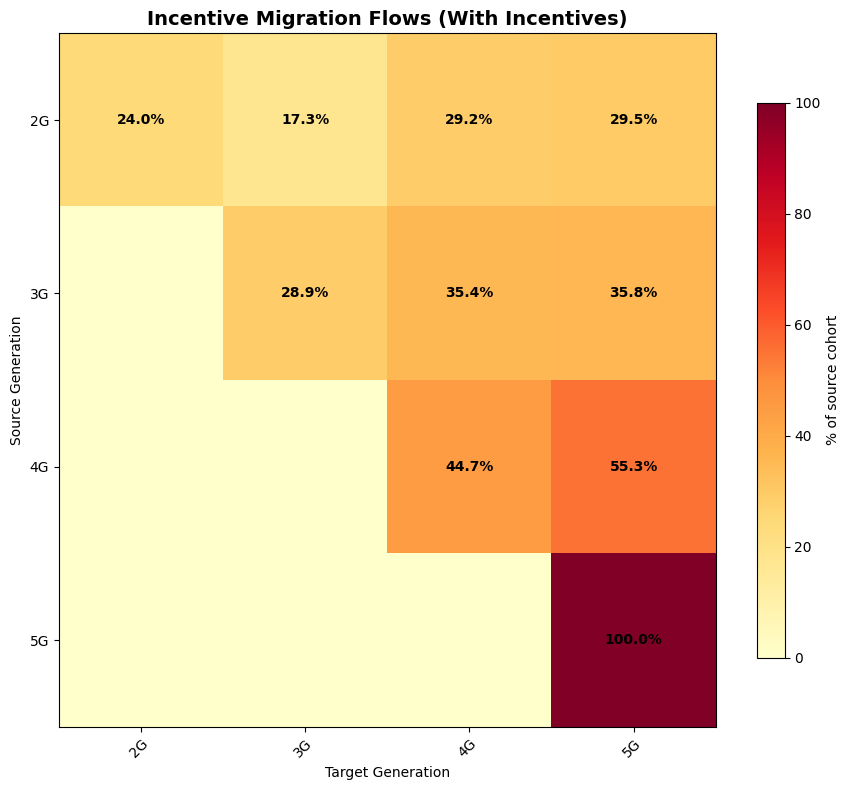

In [7]:
sim.create_migration_flow_sankey()


------------------------------------------------------------------------------------------------------------------------------------------

## 8. Visualize Overall Migration Rate 

This cell produces **two charts** comparing overall migration rates between the Baseline and Incentive scenarios (eligible users; 5G starters excluded).

Offers a clean visual snapshot of overall migration improvement.


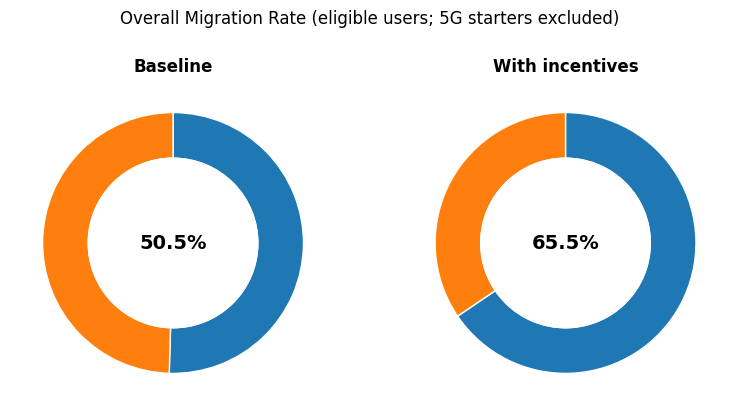

In [8]:
draw_two_donuts(
    sim.baseline_results['migration_rate_excl_5g'],
    sim.treatment_results['migration_rate_excl_5g']
)


------------------------------------------------------------------------------------------------------------------------------------------

## 9. Evaluate Individual Incentive Effectiveness

This cell isolates each incentive type to measure its independent effect on migration. It runs three simulations, each activating only one incentive at a time and presents the results.

Enables direct comparison of how strongly each incentive influences user migration behavior.


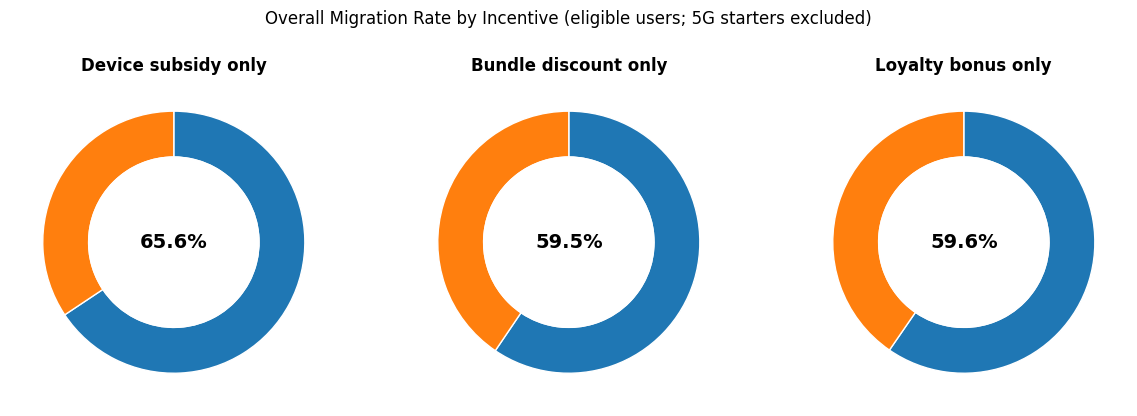

In [9]:
plot_incentive_migration_rate_donuts(num_users=100_000)
